# **First** autoencoder

In [91]:
import numpy as np
import torch
import torch.nn as nn

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

In [92]:
N_Samples=500
N_PeriodicGenes=10
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.04

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()


Select gene you are interested setting varaible g in order to plot data, and supposed distribution

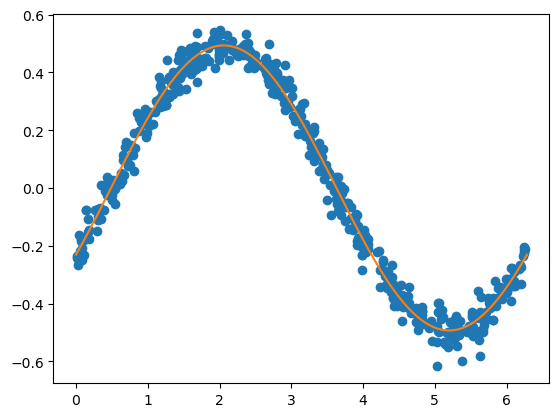

In [93]:
g=0
if g < N_PeriodicGenes:
    a=alpha[g,:]
    x=np.linspace(0,2*np.pi, 400)
    def f(x):
        return np.cos(x)*a[0]+ np.sin(x)*a[1]
    plt.plot(true_phases, E[g,:].reshape((N_Samples,1)), 'o',x,f(x))
else:
    plt.plot(true_phases, E[g,:].reshape((N_Samples,1)), 'o')



## PCA

In [94]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

/Users/salati/anaconda3/envs/AE-env/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


PCA(n_components=2)

In [95]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  2.7376104855258987e-17


In [96]:
pca_points=pca.fit_transform(Et)

/Users/salati/anaconda3/envs/AE-env/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


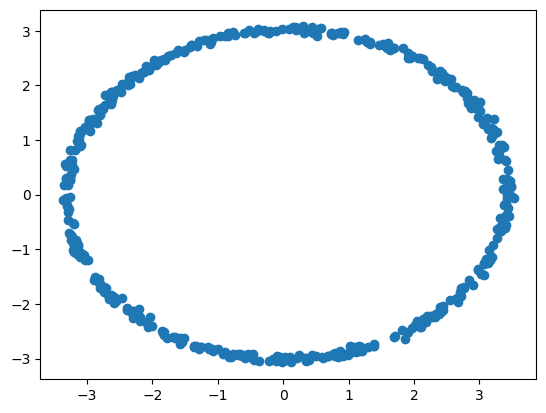

In [97]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [98]:
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])

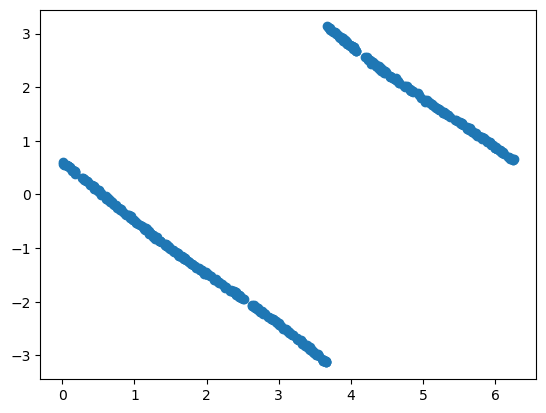

In [99]:
plt.plot(true_phases,PCA_phi, 'o')

## Torch Linear

### Setting the network

In [100]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()

In [101]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [102]:
model = LinearEncoder()
criterion= nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)


Adding the GPU stuff

In [103]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line
DATA=torch.from_numpy(E)
DATA=DATA.float()

Training cycle

In [104]:
#recon= reconstruction of the input
num_epochs=200
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 0.0013853567652404308
epoch  10 Loss 0.0013858007732778788
epoch  20 Loss 0.0013860603794455528
epoch  30 Loss 0.0013862099731341004
epoch  40 Loss 0.0013863288331776857
epoch  50 Loss 0.001386398682370782
epoch  60 Loss 0.0013864373322576284
epoch  70 Loss 0.0013864663196727633
epoch  80 Loss 0.0013864848297089338
epoch  90 Loss 0.001386492745950818
epoch  100 Loss 0.0013864977518096566
epoch  110 Loss 0.0013864989159628749
epoch  120 Loss 0.0013865061337128282
epoch  130 Loss 0.00138650625012815
epoch  140 Loss 0.00138650625012815
epoch  150 Loss 0.0013865061337128282
epoch  160 Loss 0.0013865045038983226
epoch  170 Loss 0.0013865006621927023
epoch  180 Loss 0.001386496820487082
epoch  190 Loss 0.0013865006621927023


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [105]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [106]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(-2.8580e-06, grad_fn=<DotBackward0>)

In [107]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

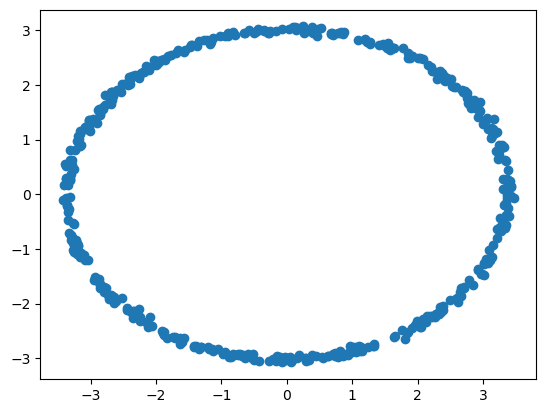

In [108]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [109]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )

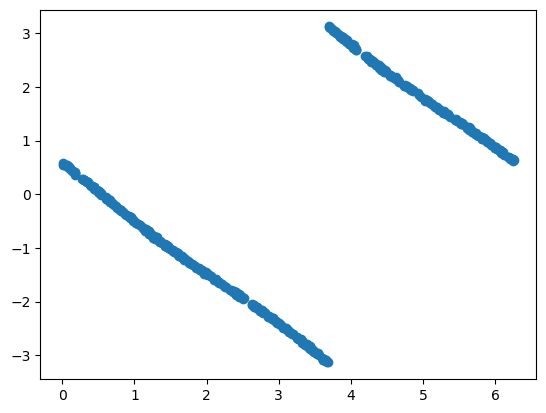

In [110]:
plt.plot(true_phases,inf_phases,'o')

## Adding the "circular" activation function

### Setting the network

In [111]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [112]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [113]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [114]:
#recon= reconstruction of the input
num_epochs=100
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 5 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 0.23884037137031555
epoch  5 Loss 0.002842735033482313
epoch  10 Loss 0.0020584671292454004
epoch  15 Loss 0.002217190572991967
epoch  20 Loss 0.0022973923478275537
epoch  25 Loss 0.002322802087292075
epoch  30 Loss 0.002333494136109948
epoch  35 Loss 0.002341433195397258
epoch  40 Loss 0.0023495261557400227
epoch  45 Loss 0.002358575351536274
epoch  50 Loss 0.0023687181528657675
epoch  55 Loss 0.0023797466419637203
epoch  60 Loss 0.0023908624425530434
epoch  65 Loss 0.0024002366699278355
epoch  70 Loss 0.002404742408543825
epoch  75 Loss 0.002401156583800912
epoch  80 Loss 0.002388683147728443
epoch  85 Loss 0.0023697037249803543
epoch  90 Loss 0.0023475016932934523
epoch  95 Loss 0.002325762528926134


In [115]:
circ_encoder_base=circ_model.encoder.weight
#print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)

After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [116]:
NNphasesC=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[sample,:]=temp
  NNphasesC[sample,:] /= np.linalg.norm(NNphasesC[sample,:])

np.linalg.norm( NNphases[9,:] )

3.322787340731691

In [117]:
#plt.plot(NNphasesC[:,0], NNphasesC[:,1],'o')

In [118]:
inf_phasesC=np.arctan2( NNphasesC[:,0],NNphasesC[:,1] )

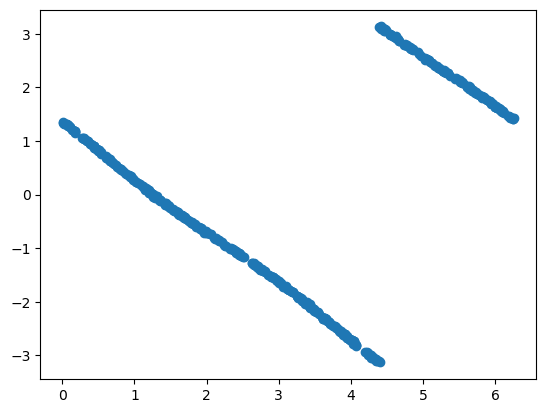

In [119]:
plt.plot(true_phases,inf_phasesC,'o')